In [2]:
!pip install keras-facenet --quiet
!pip install mtcnn imgaug --quiet

# Import thư viện

In [25]:
import os
import random
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pickle

from mtcnn.mtcnn import MTCNN
import imgaug.augmenters as iaa

from keras.models import load_model, Sequential
from keras.layers import Dense, Dropout, Input
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import LabelEncoder, Normalizer
from sklearn.metrics import accuracy_score, classification_report

from keras_facenet import FaceNet

# Load & tăng cường dữ liệu

In [4]:
dataset_dir = '/kaggle/input/facedataset/SortedFaces/'
base_output_dir = '/kaggle/working/SortedFacesSplit/'

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

os.makedirs(base_output_dir, exist_ok=True)

for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(base_output_dir, split), exist_ok=True)

for person in os.listdir(dataset_dir):
    person_dir = os.path.join(dataset_dir, person)
    if not os.path.isdir(person_dir):
        continue
    images = [f for f in os.listdir(person_dir) if f.endswith(('.jpg', '.png'))]
    random.shuffle(images)
    
    n_total = len(images)
    n_train = int(n_total * train_ratio)
    n_val = int(n_total * val_ratio)
    n_test = n_total - n_train - n_val
    
    splits = {
        'train': images[:n_train],
        'val': images[n_train:n_train + n_val],
        'test': images[n_train + n_val:]
    }
    
    for split, files in splits.items():
        split_person_dir = os.path.join(base_output_dir, split, person)
        os.makedirs(split_person_dir, exist_ok=True)
        for f in files:
            src = os.path.join(person_dir, f)
            dst = os.path.join(split_person_dir, f)
            shutil.copy(src, dst)
    print(f'{person}: train={n_train}, val={n_val}, test={n_test}')

Alia Bhatt: train=55, val=11, test=13
hieu: train=32, val=6, test=8
Charlize Theron: train=54, val=11, test=13
Zac Efron: train=63, val=13, test=15
Billie Eilish: train=68, val=14, test=16
Jessica Alba: train=75, val=16, test=17
long: train=44, val=9, test=11
Priyanka Chopra: train=71, val=15, test=16
Natalie Portman: train=73, val=15, test=17
Hrithik Roshan: train=70, val=15, test=16
Tom Cruise: train=40, val=8, test=10
Roger Federer: train=53, val=11, test=13
Henry Cavill: train=74, val=15, test=17
Amitabh Bachchan: train=51, val=11, test=12
Brad Pitt: train=84, val=18, test=18
Dwayne Johnson: train=42, val=9, test=10
Kashyap: train=21, val=4, test=5
Elizabeth Olsen: train=49, val=10, test=12
Camila Cabello: train=60, val=13, test=14
Vijay Deverakonda: train=80, val=17, test=18
Courtney Cox: train=56, val=12, test=12
Ellen Degeneres: train=52, val=11, test=12
Margot Robbie: train=50, val=10, test=12
Anushka Sharma: train=47, val=10, test=11
Lisa Kudrow: train=49, val=10, test=11
Marm

In [7]:
detector = MTCNN()

def extract_face(filename, required_size=(160,160)):
    image = Image.open(filename)
    image = image.convert('RGB')
    pixels = np.asarray(image)
    results = detector.detect_faces(pixels)
    if len(results) == 0:
        return None
    x1, y1, width, height = results[0]['box']
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    face = pixels[y1:y2, x1:x2]
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    return face_array

In [8]:
augmenter = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Affine(
        rotate=(-15, 15),
        scale=(0.9, 1.1)
    ),
    iaa.Multiply((0.8, 1.2)),
    iaa.AdditiveGaussianNoise(scale=(0, 0.05*255))
])

In [9]:
def load_face_with_augmentation(dir, augmenter, augment_times=5):
    faces = []
    for filename in os.listdir(dir):
        path = os.path.join(dir, filename)
        face = extract_face(path)
        if face is None:
            continue
        faces.append(face)
        for _ in range(augment_times):
            aug_face = augmenter(image=face)
            faces.append(aug_face)
    return faces

In [10]:
def load_dataset_with_aug(dir, augmenter, augment_times=5):
    X, y = [], []
    for subdir in os.listdir(dir):
        path = os.path.join(dir, subdir)
        if not os.path.isdir(path):
            continue
        faces = load_face_with_augmentation(path, augmenter, augment_times)
        labels = [subdir] * len(faces)
        print(f"Loaded {len(faces)} images for class: {subdir}")
        X.extend(faces)
        y.extend(labels)
    return np.asarray(X), np.asarray(y)

train_dir = os.path.join(base_output_dir, 'train')
val_dir = os.path.join(base_output_dir, 'val')
test_dir = os.path.join(base_output_dir, 'test')

trainX, trainy = load_dataset_with_aug(train_dir, augmenter, augment_times=5)
valX, valy = load_dataset_with_aug(val_dir, augmenter, augment_times=5)
testX, testy = load_dataset_with_aug(test_dir, augmenter, augment_times=5)

print(trainX.shape, trainy.shape)
print(valX.shape, valy.shape)
print(testX.shape, testy.shape)

Loaded 240 images for class: Tom Cruise
Loaded 402 images for class: Billie Eilish
Loaded 312 images for class: Ellen Degeneres
Loaded 408 images for class: Hrithik Roshan
Loaded 132 images for class: Marmik
Loaded 438 images for class: Natalie Portman
Loaded 66 images for class: tien
Loaded 294 images for class: Margot Robbie
Loaded 180 images for class: hieu
Loaded 330 images for class: Alia Bhatt
Loaded 294 images for class: Lisa Kudrow
Loaded 378 images for class: Zac Efron
Loaded 192 images for class: anh
Loaded 252 images for class: Dwayne Johnson
Loaded 318 images for class: Roger Federer
Loaded 210 images for class: Akshay Kumar
Loaded 444 images for class: Henry Cavill
Loaded 216 images for class: long
Loaded 336 images for class: Courtney Cox
Loaded 204 images for class: Virat Kohli
Loaded 324 images for class: Charlize Theron
Loaded 126 images for class: Kashyap
Loaded 384 images for class: Alexandra Daddario
Loaded 426 images for class: Priyanka Chopra
Loaded 294 images for

# Build model

In [12]:
embedder = FaceNet()
print("Loaded FaceNet model.")

def get_embeddings(faces):
    faces = faces.astype('float32')
    embeddings = embedder.embeddings(faces)
    return embeddings

trainX_embed = get_embeddings(trainX)
valX_embed = get_embeddings(valX)
testX_embed = get_embeddings(testX)

print("Embeddings shape (train):", trainX_embed.shape)

Loaded FaceNet model.
354/354 ━━━━━━━━━━━━━━━━━━━━ 299s 831ms/step
74/74 ━━━━━━━━━━━━━━━━━━━━ 60s 816ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 67s 807ms/step
Embeddings shape (train): (11304, 512)


In [13]:
label_encoder = LabelEncoder()
trainy_enc = label_encoder.fit_transform(trainy)
valy_enc = label_encoder.transform(valy)
testy_enc = label_encoder.transform(testy)
num_classes = len(label_encoder.classes_)

In [26]:
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

In [14]:
trainy_cat = to_categorical(trainy_enc, num_classes)
valy_cat = to_categorical(valy_enc, num_classes)

model = Sequential([
    Input(shape=(trainX_embed.shape[1],)),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')  
])

model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 35)             │         4,515 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,179 (274.14 KB)

 Trainable params: 70,179 (274.14 KB)

 Non-trainable params: 0 (0.00 B)

# Train model

In [17]:
checkpoint_path = "proxy_classifier_best.h5"

checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',    
    verbose=1,
    save_best_only=True,      
    mode='max'             
)

model.fit(
    trainX_embed, trainy_cat,
    validation_data=(valX_embed, valy_cat),
    epochs=20,
    batch_size=64,
    callbacks=[checkpoint]
)

Epoch 1/20
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6861 - loss: 2.5711
Epoch 1: val_accuracy improved from -inf to 0.97350, saving model to proxy_classifier_best.h5
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6879 - loss: 2.5605 - val_accuracy: 0.9735 - val_loss: 0.3128
Epoch 2/20
175/177 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9828 - loss: 0.2477
Epoch 2: val_accuracy improved from 0.97350 to 0.98974, saving model to proxy_classifier_best.h5
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9829 - loss: 0.2467 - val_accuracy: 0.9897 - val_loss: 0.0956
Epoch 3/20
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9932 - loss: 0.0889
Epoch 3: val_accuracy improved from 0.98974 to 0.99103, saving model to proxy_classifier_best.h5
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9932 - loss: 0.0887 - val_accuracy: 0.9910 - val_loss: 0.0554
Epoch 4/20
163/177 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9953 - loss: 0.0513
Epoch 4: val_accu

# Test model

In [21]:
test_preds = model.predict(testX_embed)
test_preds_labels = np.argmax(test_preds, axis=1)

acc = accuracy_score(testy_enc, test_preds_labels)
print(f'Test Accuracy: {acc:.4f}')

print(classification_report(testy_enc, test_preds_labels, target_names=label_encoder.classes_))

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Test Accuracy: 0.9977
                    precision    recall  f1-score   support

      Akshay Kumar       1.00      1.00      1.00        48
Alexandra Daddario       1.00      1.00      1.00        90
        Alia Bhatt       1.00      1.00      1.00        78
  Amitabh Bachchan       1.00      1.00      1.00        66
      Andy Samberg       1.00      1.00      1.00        90
    Anushka Sharma       1.00      1.00      1.00        66
     Billie Eilish       1.00      1.00      1.00        90
         Brad Pitt       1.00      1.00      1.00       108
    Camila Cabello       1.00      1.00      1.00        84
   Charlize Theron       0.99      1.00      0.99        78
       Claire Holt       1.00      1.00      1.00        90
      Courtney Cox       1.00      0.99      0.99        72
    Dwayne Johnson       1.00      1.00      1.00        60
   Elizabeth Olsen       1.00      1.00      1.00        72
   Ellen Degeneres       1.00      1.0

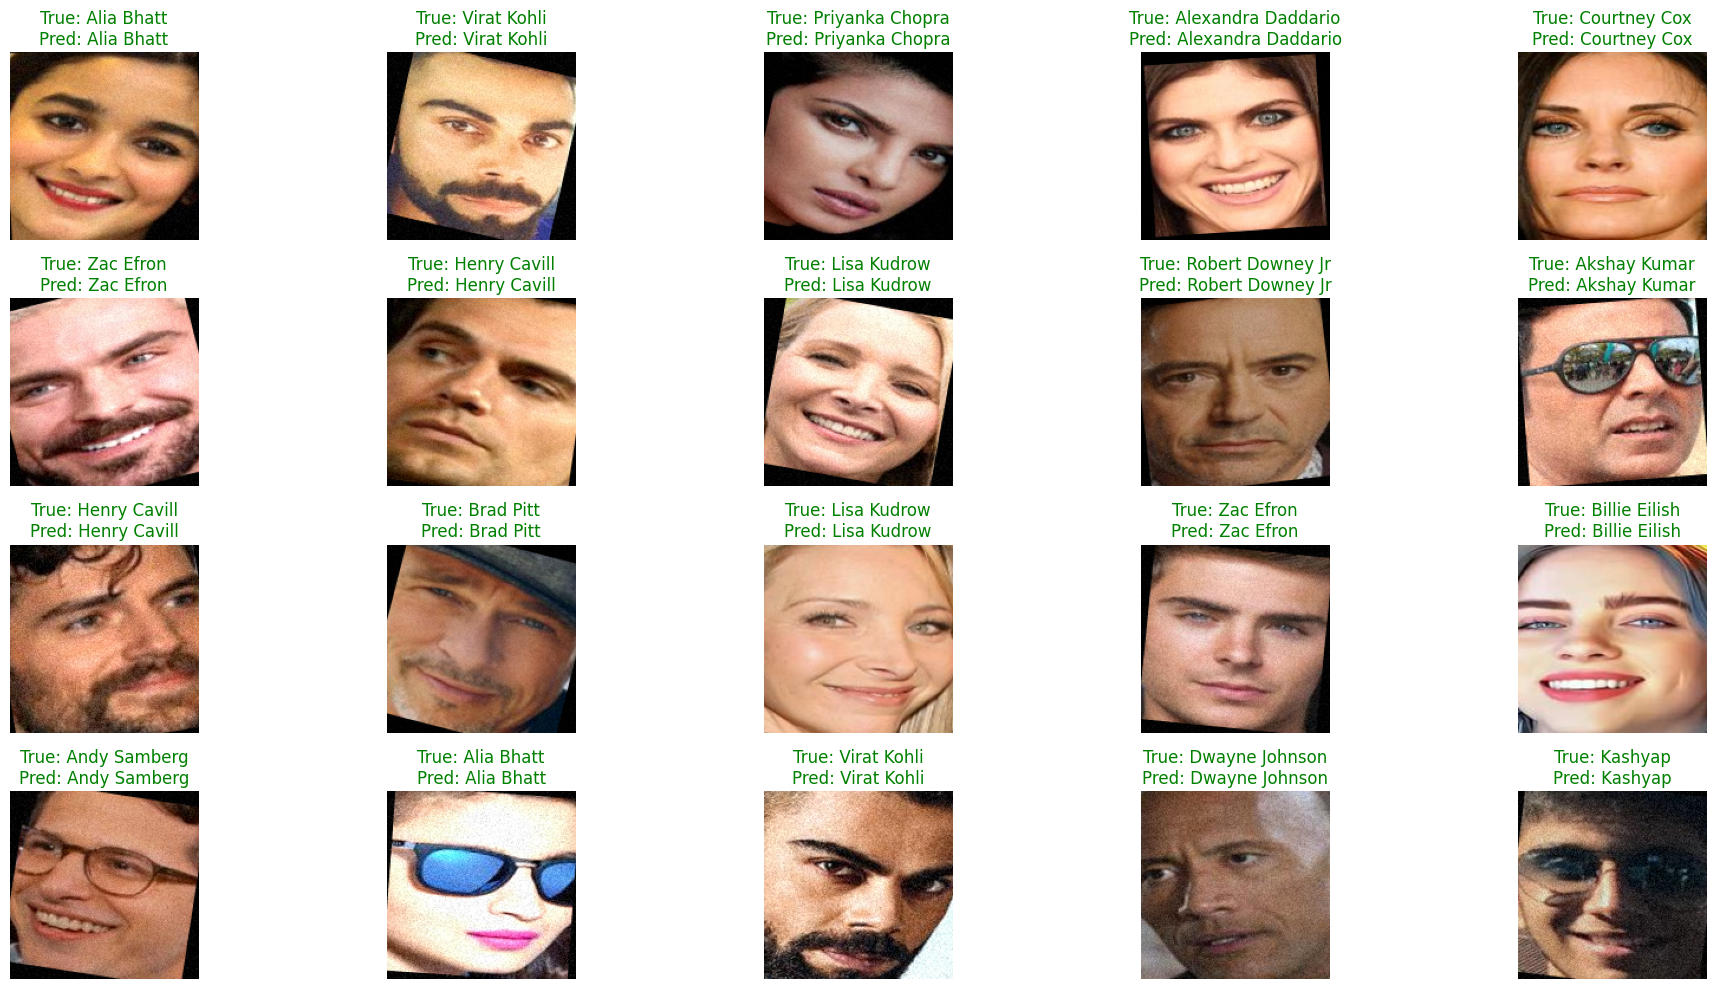

In [22]:
num_display = 20
indices = random.sample(range(len(testX)), num_display)

plt.figure(figsize=(20, 10))
for i, idx in enumerate(indices):
    img = testX[idx]
    true_label = label_encoder.inverse_transform([testy_enc[idx]])[0]
    pred_label = label_encoder.inverse_transform([test_preds_labels[idx]])[0]
    
    color = 'green' if true_label == pred_label else 'red'
    
    plt.subplot(4, 5, i+1)
    plt.imshow(img.astype('uint8'))
    plt.title(f'True: {true_label}\nPred: {pred_label}', color=color)
    plt.axis('off')
plt.tight_layout()
plt.show()